In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download abdallahalidev/plantvillage-dataset
! unzip -q /content/plantvillage-dataset.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
 99% 2.02G/2.04G [00:17<00:00, 143MB/s]
100% 2.04G/2.04G [00:17<00:00, 123MB/s]


In [7]:
import os
import shutil
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [8]:
import tensorflow as tf
import keras
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Conv2D , MaxPooling2D , Dropout , Activation , BatchNormalization, GlobalAveragePooling2D, Input, multiply, GlobalMaxPooling2D, Flatten
from tensorflow.keras.optimizers import Nadam, AdamW, Adam, Lion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers

In [9]:
source_dir = '/content/plantvillage dataset/color'
target_dir = '/content/my_dataset'


Path(target_dir).mkdir(parents=True, exist_ok=True)
train_dir = os.path.join(target_dir, 'train')
test_dir = os.path.join(target_dir, 'test')
valid_dir = os.path.join(target_dir, 'valid')

for dir_path in [train_dir, test_dir, valid_dir]:
    Path(dir_path).mkdir(parents=True, exist_ok=True)

classes = os.listdir(source_dir)


for class_name in classes:
    class_path = os.path.join(source_dir, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)
    num_images = len(images)
    train_split = int(0.8 * num_images)
    test_split = int(0.1 * num_images)
    valid_split = num_images - train_split - test_split

    train_images = images[:train_split]
    test_images = images[train_split:train_split+test_split]
    valid_images = images[train_split+test_split:]


    for img_name in train_images:
        src = os.path.join(class_path, img_name)
        dest = os.path.join(train_dir, class_name, img_name)
        Path(os.path.join(train_dir, class_name)).mkdir(parents=True, exist_ok=True)
        shutil.copy(src, dest)

    for img_name in test_images:
        src = os.path.join(class_path, img_name)
        dest = os.path.join(test_dir, class_name, img_name)
        Path(os.path.join(test_dir, class_name)).mkdir(parents=True, exist_ok=True)
        shutil.copy(src, dest)

    for img_name in valid_images:
        src = os.path.join(class_path, img_name)
        dest = os.path.join(valid_dir, class_name, img_name)
        Path(os.path.join(valid_dir, class_name)).mkdir(parents=True, exist_ok=True)
        shutil.copy(src, dest)

In [10]:
def create_dataframe_from_directory(directory):
    filepaths = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):  # Проверяем, что это действительно папка
            for filename in os.listdir(label_dir):
                filepath = os.path.join(label_dir, filename)
                filepaths.append(filepath)
                labels.append(label)  # Используем название папки как метку
    df = pd.DataFrame({'Filepaths': filepaths, 'Labels': labels})
    return df

train_dir = '/content/my_dataset/train'
test_dir = '/content/my_dataset/test'
valid_dir = '/content/my_dataset/valid'

In [11]:
train_df = create_dataframe_from_directory(train_dir)
valid_df = create_dataframe_from_directory(valid_dir)
test_df = create_dataframe_from_directory(test_dir)

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.2
# )


valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 43429 validated image filenames belonging to 38 classes.
Found 5459 validated image filenames belonging to 38 classes.
Found 5417 validated image filenames belonging to 38 classes.


# MobileNet + AdamW

In [8]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=3,
                               verbose=1,
                               restore_best_weights=True,
                               mode='max',
                               min_delta=0.01,
                               baseline=0.90)

model_checkpoint = ModelCheckpoint('MobuleNet+AdamW.h5',
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   mode='max',
                                   verbose=1)

In [15]:
base_model = MobileNet(weights= 'imagenet',
                       include_top = False,
                       input_shape = (224,224,3),
                       pooling = 'avg')

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-40:]:
    layer.trainable = True


model2 = Sequential()
model2.add(base_model)
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dropout(0.35))
model2.add(layers.Dense(38, activation='softmax'))

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 1024)              3228864   
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 16)                16400     
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 38)                646       
                                                                 
Total params: 3245910 (12.38 MB)
Trainable params: 2687126 (10.25 MB)
Non-trainable params: 558784 (2.13 MB)
_________________________________________________________________


In [16]:
initial_learning_rate = 0.001
schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

optimizer = AdamW(learning_rate=schedule, weight_decay=1e-4)
model2.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
%%time
history = model2.fit(
    train_generator,
    validation_data=valid_generator,
    epochs = 5,
    shuffle= False,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/5
1358/1358 [==============================] - ETA: 0s - loss: 1.2078 - accuracy: 0.6386
Epoch 1: val_accuracy improved from -inf to 0.88533, saving model to MobuleNet+AdamW.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1358/1358 [==============================] - 571s 414ms/step - loss: 1.2078 - accuracy: 0.6386 - val_loss: 0.3794 - val_accuracy: 0.8853
Epoch 2/5
1358/1358 [==============================] - ETA: 0s - loss: 0.6474 - accuracy: 0.7874
Epoch 2: val_accuracy improved from 0.88533 to 0.93900, saving model to MobuleNet+AdamW.h5
1358/1358 [==============================] - 562s 414ms/step - loss: 0.6474 - accuracy: 0.7874 - val_loss: 0.2052 - val_accuracy: 0.9390
Epoch 3/5
1357/1358 [============================>.] - ETA: 0s - loss: 0.5250 - accuracy: 0.8250
Epoch 3: val_accuracy improved from 0.93900 to 0.96611, saving model to MobuleNet+AdamW.h5
1358/1358 [==============================] - 574s 423ms/step - loss: 0.5252 - accuracy: 0.8250 - val_loss: 0.1122 - val_accuracy: 0.9661
Epoch 4/5
1357/1358 [============================>.] - ETA: 0s - loss: 0.4856 - accuracy: 0.8403
Epoch 4: val_accuracy improved from 0.96611 to 0.97362, saving model to MobuleNet+AdamW.h5
1358/1358 [==============

In [18]:
model2.save('MobileNet+AdamW.h5')

In [19]:
test_loss, test_accuracy = model2.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

170/170 [==============================] - 11s 64ms/step - loss: 0.0735 - accuracy: 0.9795
Test Accuracy: 0.9795089364051819


In [20]:
test_predictions = model2.predict(test_generator)
test_predicted_labels = np.argmax(test_predictions, axis=1)


test_true_labels = test_generator.classes
error_df = pd.DataFrame({'True Label': test_true_labels, 'Predicted Label': test_predicted_labels})
misclassified_images = error_df[error_df['True Label'] != error_df['Predicted Label']]

170/170 [==============================] - 11s 63ms/step


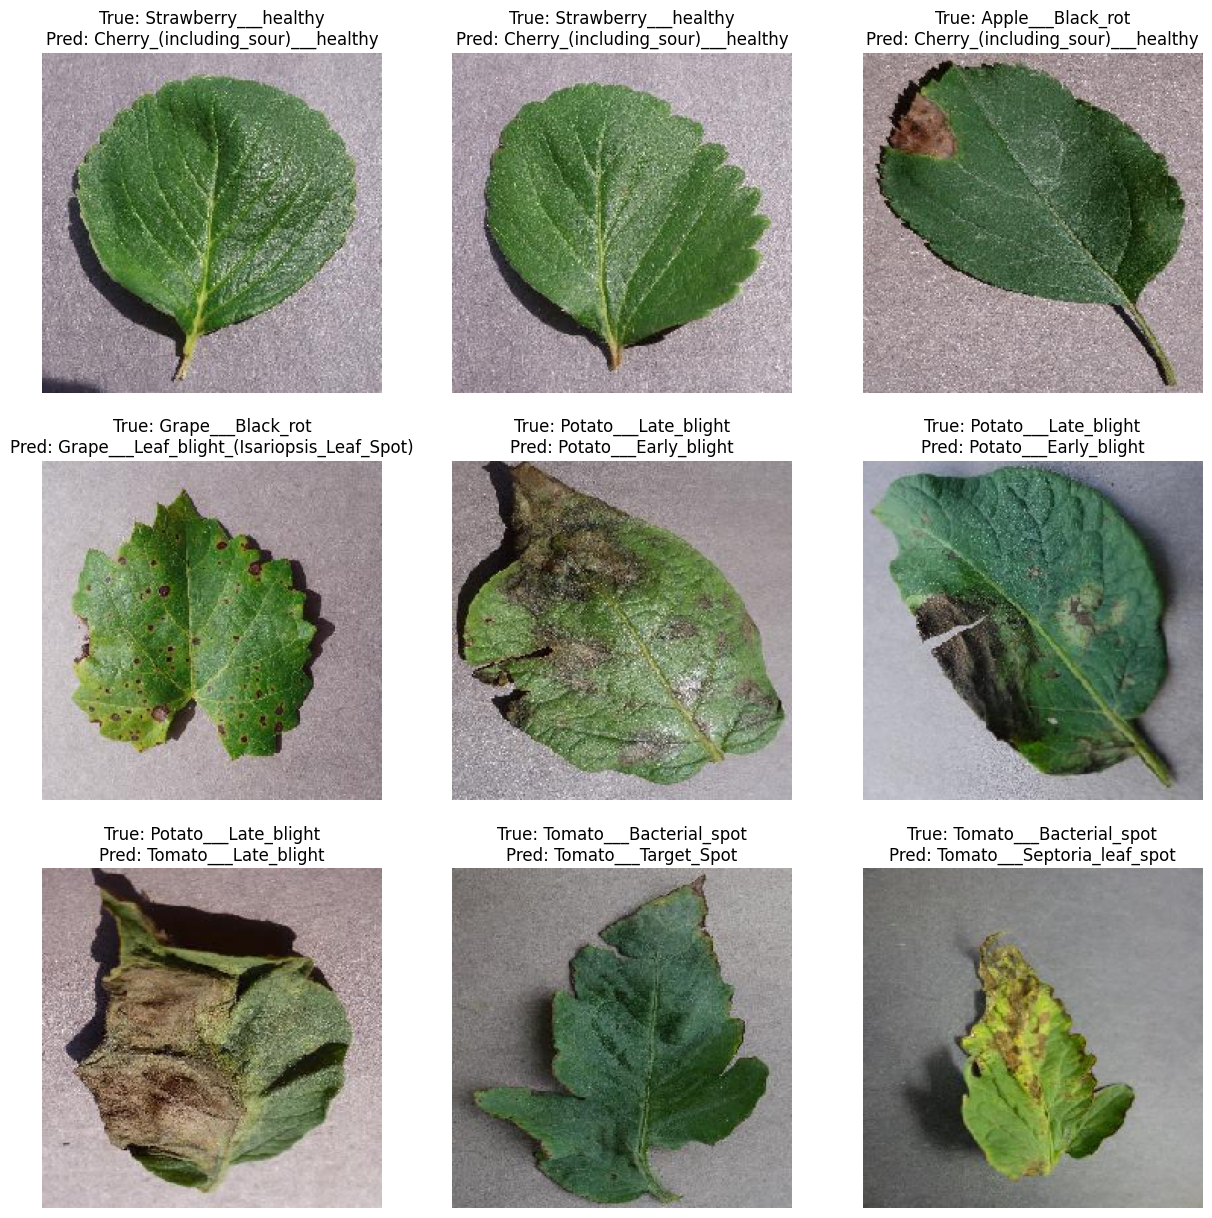

In [21]:
class_folds = {v: k for k, v in train_generator.class_indices.items()}
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(15, 15))
for i, row in enumerate(misclassified_images.head(9).itertuples()):
    img_path = test_df.iloc[row.Index]['Filepaths']
    img = keras_image.load_img(img_path, target_size=(224, 224))
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    true_label = class_folds[row._1]  # Use 'True Label' as defined in error_df
    pred_label = class_folds[row._2]  # Use 'Predicted Label' as defined in error_df
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.show()

In [22]:
test_generator.reset()
pred = model2.predict(test_generator)
predicted_class_indices = np.argmax(pred, axis=1)

# Get the true labels
true_class_indices = test_generator.classes

# Generate and print the classification report
print(classification_report(true_class_indices, predicted_class_indices, target_names=class_names))


170/170 [==============================] - 11s 65ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.91      1.00      0.95        63
                                 Apple___Black_rot       1.00      0.98      0.99        62
                          Apple___Cedar_apple_rust       1.00      0.78      0.88        27
                                   Apple___healthy       1.00      0.99      0.99       164
                               Blueberry___healthy       1.00      1.00      1.00       150
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       105
                 Cherry_(including_sour)___healthy       0.97      1.00      0.98        85
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.80      0.84      0.82        51
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       119
               Corn_(m

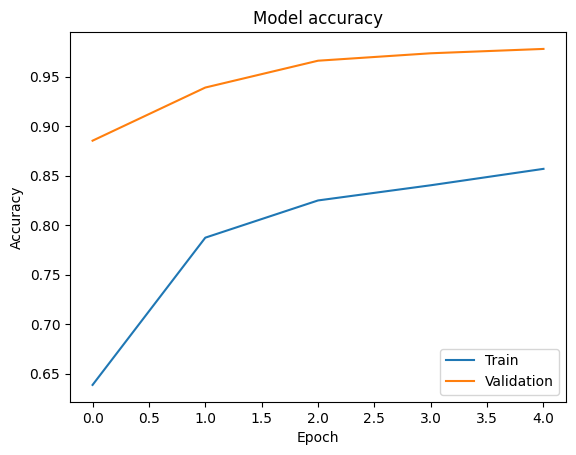

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

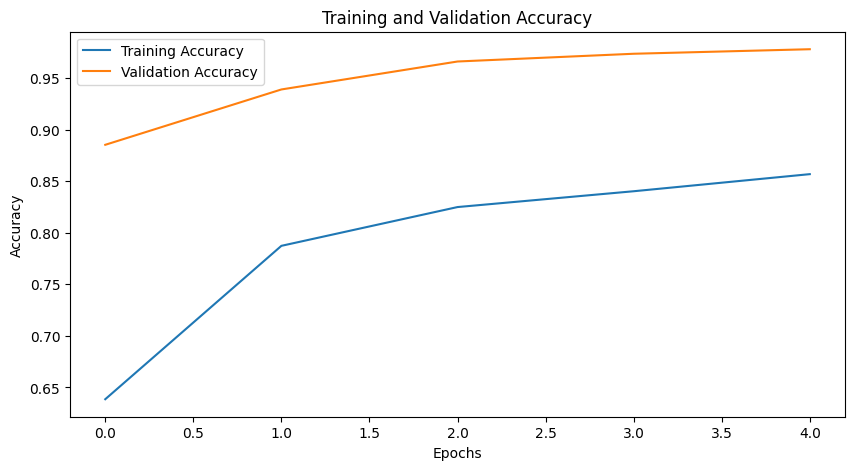

In [24]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Створюємо графік
plt.figure(figsize=(10, 5))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# MobileNet + Nadam

In [26]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=3,
                               verbose=1,
                               restore_best_weights=True,
                               mode='max',
                               min_delta=0.01,
                               baseline=0.90)

model_checkpoint = ModelCheckpoint('MobileNet+Nadam.h5',
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   mode='max',
                                   verbose=1)

In [27]:
base_model = MobileNet(weights= 'imagenet',
                       include_top = False,
                       input_shape = (224,224,3),
                       pooling = 'avg')

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-40:]:
    layer.trainable = True


model = Sequential()
model.add(base_model)
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(38, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 1024)              3228864   
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 16)                16400     
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 38)                646       
                                                                 
Total params: 3245910 (12.38 MB)
Trainable params: 2687126 (10.25 MB)
Non-trainable params: 558784 (2.13 MB)
_________________________________________________________________


In [28]:
model.compile(optimizer='Nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
%%time
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs = 5,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/5
1358/1358 [==============================] - ETA: 0s - loss: 1.0804 - accuracy: 0.6754
Epoch 1: val_accuracy improved from -inf to 0.89357, saving model to MobileNet+Nadam.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1358/1358 [==============================] - 594s 427ms/step - loss: 1.0804 - accuracy: 0.6754 - val_loss: 0.3668 - val_accuracy: 0.8936
Epoch 2/5
1358/1358 [==============================] - ETA: 0s - loss: 0.6128 - accuracy: 0.8020
Epoch 2: val_accuracy improved from 0.89357 to 0.94266, saving model to MobileNet+Nadam.h5
1358/1358 [==============================] - 562s 414ms/step - loss: 0.6128 - accuracy: 0.8020 - val_loss: 0.1698 - val_accuracy: 0.9427
Epoch 3/5
1358/1358 [==============================] - ETA: 0s - loss: 0.5031 - accuracy: 0.8331
Epoch 3: val_accuracy improved from 0.94266 to 0.95292, saving model to MobileNet+Nadam.h5
1358/1358 [==============================] - 567s 418ms/step - loss: 0.5031 - accuracy: 0.8331 - val_loss: 0.1687 - val_accuracy: 0.9529
Epoch 4/5
1358/1358 [==============================] - ETA: 0s - loss: 0.4539 - accuracy: 0.8466
Epoch 4: val_accuracy improved from 0.95292 to 0.95952, saving model to MobileNet+Nadam.h5
1358/1358 [==============

In [30]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

170/170 [==============================] - 11s 63ms/step - loss: 0.0830 - accuracy: 0.9729
Test Accuracy: 0.9728631973266602


In [31]:
test_predictions = model.predict(test_generator)
test_predicted_labels = np.argmax(test_predictions, axis=1)


test_true_labels = test_generator.classes
error_df = pd.DataFrame({'True Label': test_true_labels, 'Predicted Label': test_predicted_labels})
misclassified_images = error_df[error_df['True Label'] != error_df['Predicted Label']]

170/170 [==============================] - 11s 61ms/step


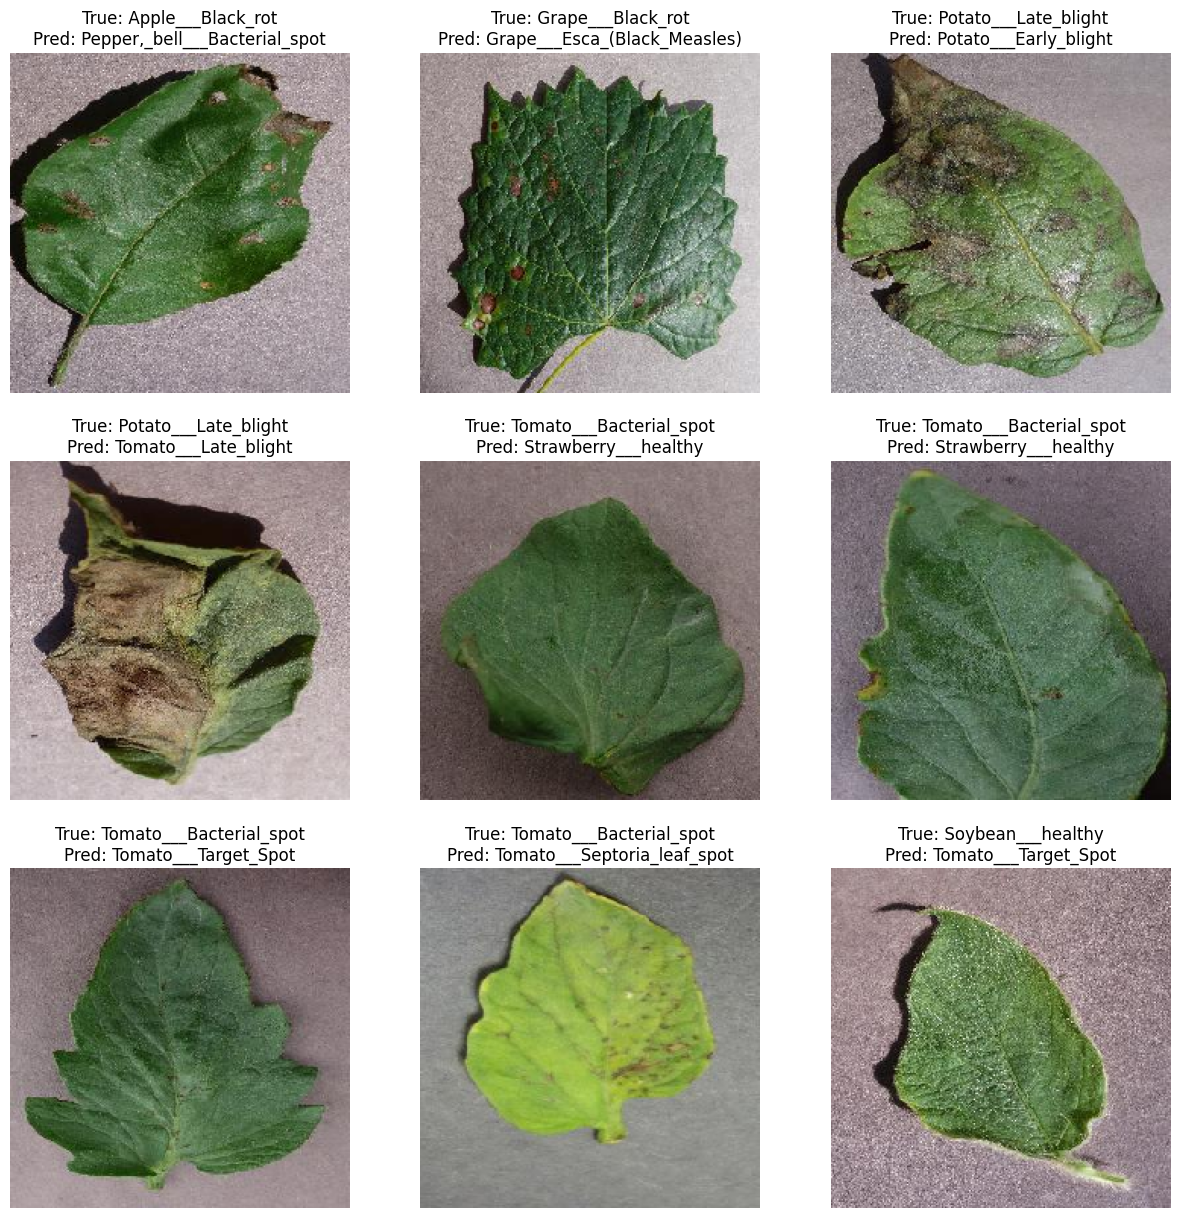

In [32]:
class_folds = {v: k for k, v in train_generator.class_indices.items()}
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(15, 15))
for i, row in enumerate(misclassified_images.head(9).itertuples()):
    img_path = test_df.iloc[row.Index]['Filepaths']
    img = keras_image.load_img(img_path, target_size=(224, 224))
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    true_label = class_folds[row._1]  # Use 'True Label' as defined in error_df
    pred_label = class_folds[row._2]  # Use 'Predicted Label' as defined in error_df
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.show()

In [33]:
test_generator.reset()
pred = model.predict(test_generator)
predicted_class_indices = np.argmax(pred, axis=1)

# Get the true labels
true_class_indices = test_generator.classes

# Generate and print the classification report
print(classification_report(true_class_indices, predicted_class_indices, target_names=class_names))

170/170 [==============================] - 10s 61ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.95      0.98        63
                                 Apple___Black_rot       0.95      0.98      0.97        62
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        27
                                   Apple___healthy       0.99      0.99      0.99       164
                               Blueberry___healthy       0.99      1.00      1.00       150
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      1.00       105
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00        85
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00        51
                       Corn_(maize)___Common_rust_       1.00      0.99      1.00       119
               Corn_(m

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


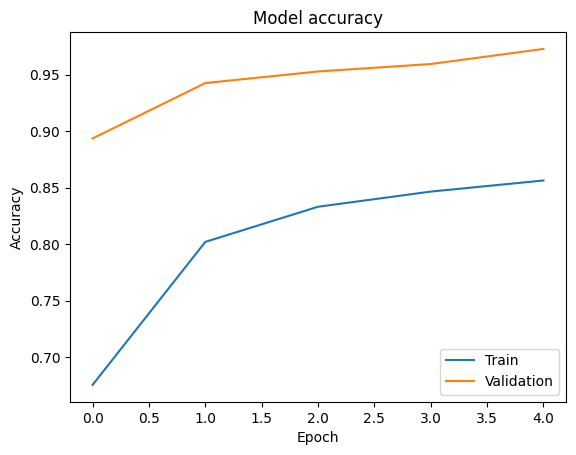

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

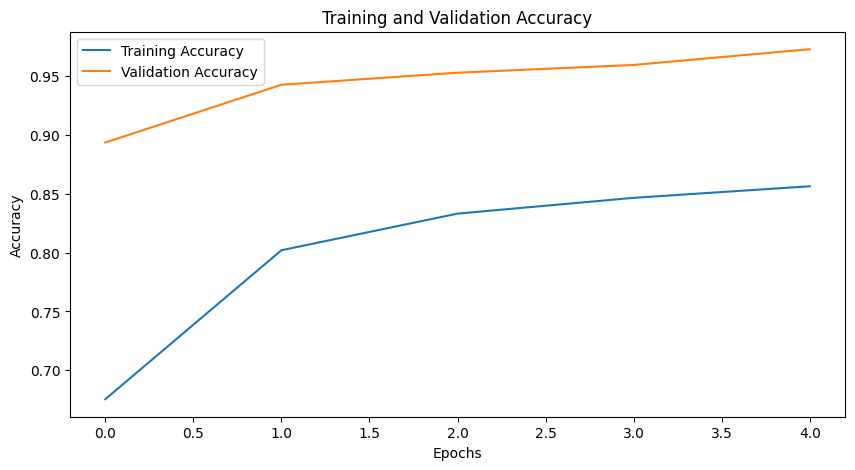

In [35]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Створюємо графік
plt.figure(figsize=(10, 5))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()